In [1]:
KERAS_MODELS_ABSOLUTE_PATH = '/content/gdrive/My Drive/esp32-dcnn13'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pip install -qq tensorflow-datasets -U
!tfds --version

TensorFlow Datasets: 4.4.0


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)
plt.rc('figure', figsize=(13, 4))

2.7.0


In [5]:
if not tf.io.gfile.exists(KERAS_MODELS_ABSOLUTE_PATH):
  print('You should create', KERAS_MODELS_ABSOLUTE_PATH, 'directory manually')
  assert False

In [6]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.42.41.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.42.41.146:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [7]:
def spectrogram_masking(spectrogram, dim=1, masks_number=2, mask_max_size=5):
  """Spectrogram masking on frequency or time dimension.
  Args:
    spectrogram: Input spectrum [batch, time, frequency]
    dim: dimension on which masking will be applied: 1 - time; 2 - frequency
    masks_number: number of masks
    mask_max_size: mask max size
  Returns:
    masked spectrogram
  """
  if dim not in (1, 2):
    raise ValueError('Wrong dim value: %d' % dim)
  input_shape = spectrogram.shape
  time_size, frequency_size = input_shape[1:3]
  dim_size = input_shape[dim]  # size of dimension on which mask is applied
  stripe_shape = [1, time_size, frequency_size]
  for _ in range(masks_number):
    mask_end = tf.random.uniform([], 0, mask_max_size, tf.int32)
    mask_start = tf.random.uniform([], 0, dim_size - mask_end, tf.int32)

    # initialize stripes with stripe_shape
    stripe_ones_left = list(stripe_shape)
    stripe_zeros_center = list(stripe_shape)
    stripe_ones_right = list(stripe_shape)

    # update stripes dim
    stripe_ones_left[dim] = dim_size - mask_start - mask_end
    stripe_zeros_center[dim] = mask_end
    stripe_ones_right[dim] = mask_start

    # generate mask
    mask = tf.concat((
        tf.ones(stripe_ones_left, spectrogram.dtype),
        tf.zeros(stripe_zeros_center, spectrogram.dtype),
        tf.ones(stripe_ones_right, spectrogram.dtype),
    ), dim)
    spectrogram = spectrogram * mask
  return spectrogram

In [8]:
def train_model(model, train_dataset, valid_dataset):

  with strategy.scope():
    tpu_model = keras.Model.from_config(model.get_config())
    tpu_model.compile(
      loss=keras.losses.BinaryCrossentropy(from_logits=True),
      optimizer=keras.optimizers.Adam(),
      metrics=['accuracy'])

  early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1,
        patience=100,
        restore_best_weights=True)

  tpu_num_cores = resolver.get_tpu_system_metadata().num_cores

  train_batch = train_dataset.shuffle(train_dataset.cardinality())
  train_batch = train_batch.batch(tpu_num_cores * 64, drop_remainder=True)
  train_batch = train_batch.map(lambda x, y: (spectrogram_masking(x, 1, 3, 3), y))
  train_batch = train_batch.map(lambda x, y: (spectrogram_masking(x, 2, 2, 2), y))
  train_batch = train_batch.prefetch(tf.data.AUTOTUNE)

  valid_batch = valid_dataset.batch(8, drop_remainder=True)
  valid_batch = valid_batch.prefetch(tf.data.AUTOTUNE)

  # plt.imshow(list(train_batch.take(1))[0][0][0].numpy().T)
  # plt.show()

  history = tpu_model.fit(train_batch,
                          validation_data=valid_batch,
                          callbacks=[early_stopping],
                          verbose=2,
                          epochs=1000) # play with google colab time limit

  model.set_weights(early_stopping.best_weights)
  return history

In [9]:
# https://arxiv.org/pdf/2005.06720.pdf

def streaming_input_output(streaming, t, inputs, otputs, x):
  if streaming:
    otputs.append(x)
    x = keras.Input(shape=[t] + x.shape[2:])
    inputs.append(x)
  return x

def build_model(streaming=False):

  # resetting the layer name generation counter
  keras.backend.clear_session()

  inputs  = []
  outputs = []

  x_in = keras.Input(shape=[1, 1, 13] if streaming else [47, 13])
  x = x_in if streaming else keras.backend.expand_dims(x_in, -2)

  x = keras.layers.Conv2D(32, 1, use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  x = keras.layers.SpatialDropout2D(x.shape[-1]/1280.0)(x)

  for i in range(4):
    x = streaming_input_output(streaming, 2, inputs, outputs, x)
    x = keras.layers.SeparableConv2D(x.shape[-1], kernel_size=[2, 1], 
                                     dilation_rate=[1 if streaming else 2**i, 1], 
                                     use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.SpatialDropout2D(x.shape[-1]/1280.0)(x)

  x = streaming_input_output(streaming, 32, inputs, outputs, x)
  x = keras.layers.AveragePooling2D([x.shape[1], 1])(x)
  x = keras.layers.Flatten()(x)

  x = keras.layers.Dense(x.shape[-1] // 2, use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  x = keras.layers.Dropout(x.shape[-1]/1280.0)(x)

  x = keras.layers.Dense(1)(x)

  model = keras.Model(inputs=[x_in] + inputs, outputs=[x] + outputs)

  return model

In [10]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 47, 13)]          0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 47, 1, 13)        0         
                                                                 
 conv2d (Conv2D)             (None, 47, 1, 32)         416       
                                                                 
 batch_normalization (BatchN  (None, 47, 1, 32)        128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 47, 1, 32)         0         
                                                                 
 spatial_dropout2d (SpatialD  (None, 47, 1, 32)        0         
 ropout2D)                                                   

In [11]:
(train_dataset, test_dataset, valid_dataset), info = tfds.load(
    name='my_dataset', split=['train', 'test', 'valid'],
    data_dir='gs://tfds-libri-1.appspot.com',
    as_supervised=True, try_gcs=True, with_info=True)
assert info.homepage == 'https://github.com/42io/dataset/tree/master/openslr_libri'
train_dataset.cardinality().numpy()

1825800

In [12]:
train_dataset = train_dataset.map(lambda x, y: (x[1:-1], y))
test_dataset  = test_dataset.map(lambda x, y:  (x[1:-1], y))
valid_dataset = valid_dataset.map(lambda x, y: (x[1:-1], y))

In [13]:
history = train_model(model, train_dataset, valid_dataset)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/1000
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


3566/3566 - 70s - loss: 0.1608 - accuracy: 0.9303 - val_loss: 0.0612 - val_accuracy: 0.9791 - 70s/epoch - 20ms/step
Epoch 2/1000
3566/3566 - 57s - loss: 0.0898 - accuracy: 0.9654 - val_loss: 0.0485 - val_accuracy: 0.9852 - 57s/epoch - 16ms/step
Epoch 3/1000
3566/3566 - 54s - loss: 0.0805 - accuracy: 0.9694 - val_loss: 0.0394 - val_accuracy: 0.9875 - 54s/epoch - 15ms/step
Epoch 4/1000
3566/3566 - 54s - loss: 0.0749 - accuracy: 0.9716 - val_loss: 0.0381 - val_accuracy: 0.9881 - 54s/epoch - 15ms/step
Epoch 5/1000
3566/3566 - 56s - loss: 0.0717 - accuracy: 0.9730 - val_loss: 0.0370 - val_accuracy: 0.9869 - 56s/epoch - 16ms/step
Epoch 6/1000
3566/3566 - 53s - loss: 0.0692 - accuracy: 0.9741 - val_loss: 0.0390 - val_accuracy: 0.9884 - 53s/epoch - 15ms/step
Epoch 7/1000
3566/3566 - 61s - loss: 0.0678 - accuracy: 0.9746 - val_loss: 0.0336 - val_accuracy: 0.9898 - 61s/epoch - 17ms/step
Epoch 8/1000
3566/3566 - 55s - loss: 0.0666 - accuracy: 0.9751 - val_loss: 0.0360 - val_accuracy: 0.9879 - 55s

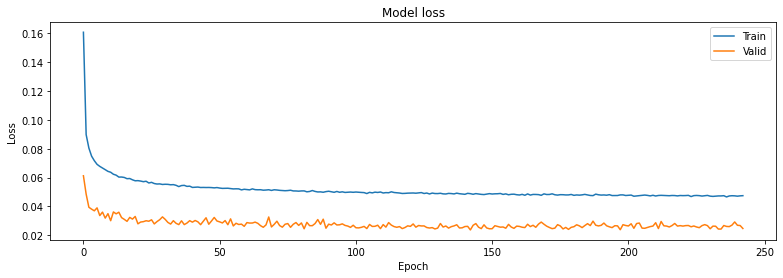

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
assert plt.legend(['Train', 'Valid'], loc='upper right')

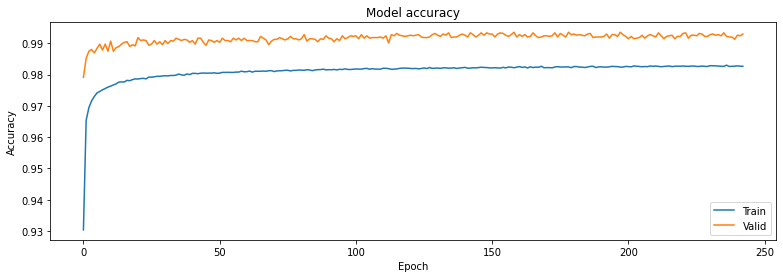

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
assert plt.legend(['Train', 'Valid'], loc='lower right')

In [17]:
pred = model.predict(test_dataset.batch(512)).squeeze(-1) > 0
print(np.sum(pred != list(test_dataset.map(lambda x, y: y))), test_dataset.cardinality().numpy())
pred = model.predict(valid_dataset.batch(512)).squeeze(-1) > 0
print(np.sum(pred != list(valid_dataset.map(lambda x, y: y))), valid_dataset.cardinality().numpy())

57 6086
37 5276


In [18]:
stream_model = build_model(True)
for layer in stream_model.layers:
  if layer.get_weights():
    print("Transfer weights for layer {}".format(layer.name))
    layer.set_weights(model.get_layer(name=layer.name).get_weights())

Transfer weights for layer dense
Transfer weights for layer batch_normalization_5
Transfer weights for layer conv2d
Transfer weights for layer separable_conv2d
Transfer weights for layer separable_conv2d_1
Transfer weights for layer separable_conv2d_2
Transfer weights for layer separable_conv2d_3
Transfer weights for layer batch_normalization
Transfer weights for layer batch_normalization_1
Transfer weights for layer batch_normalization_2
Transfer weights for layer batch_normalization_3
Transfer weights for layer batch_normalization_4
Transfer weights for layer dense_1


In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(stream_model)
tflite_model = converter.convert()
with open("dcnn13.bin.libri.tflite", "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpkslv__0y/assets


INFO:tensorflow:Assets written to: /tmp/tmpkslv__0y/assets


In [20]:
!md5sum 'dcnn13.bin.libri.tflite'
!mv 'dcnn13.bin.libri.tflite' "$KERAS_MODELS_ABSOLUTE_PATH"

20b54ae12d4a724fea497acdf084bff9  dcnn13.bin.libri.tflite
